## Usefuls sources of informations:

* https://github.com/hbjornoy/deep-learning/blob/master/project2/helpers.py
* https://github.com/Ertugrulmert/EPFL-Deep-Learning-Projects/blob/master/Project_2/framework.py
* https://github.com/marieanselmet/DeepLearningEPFL_projects/tree/main/DL_framework_from_scratch

La grande différence est que tout le monde définit module avec un argument, et non une liste * -> à voir si on doit changer pour faire comme les années précédentes ou s'il y a qqc de plus pratique

## TODO

* Pour les modules retournant une empty list sur param, enlever la fonction param (ça sert à rien de l'override)

In [1]:
import torch
import math
import time
import datetime
import random

from torch import Tensor
torch.set_grad_enabled(False)

In [2]:
# The father of all Modules
class Module(object):
    def forward(self, *input):
        raise NotImplementedError
        
    def backward(self, *gradwrtoutput):
        raise NotImplementedError
        
    def param(self):
        return []

## Activation

À part ReLU et Tanh c'est pas précisé dans l'énoncé - là c'est juste pour le flex

In [3]:
class ReLU(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        return input.clamp(0)

    def backward(self, gradwrtoutput):
        input = self.t
        sign = input.sign().clamp(0)
        return sign * gradwrtoutput
        
    def param(self):
        return []

In [4]:
class Tanh(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        
        out = []
        for x in input :
            e = math.exp(-2 * x)
            val = (1 - e) / (1 + e)
            out.append(val)
        return torch.FloatTensor(out)

    def backward(self, gradwrtoutput):
        z = self.t
        e = torch.exp(-2 * z)
        d_tanh = 4 * e / (1 + e)**2
        return d_tanh * gradwrtoutput
        
    def param(self):
        return []

In [5]:
class Sigmoid(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, input):
        self.t = input
        return input.mul(-1).exp().add(1).pow(-1)

    def backward(self, gradwrtoutput):
        sig = self.t.mul(-1).exp().add(1).pow(-1)
        return sig.mul(-1).add(1).mul(sig)
        
    def param(self):
        return []

## Layers

In [10]:
class Linear(Module):
    def __init__(self, input_size, output_size, mean=0, std=1):
        super().__init__()
        self.W = torch.empty(output_size, input_size).normal_(mean, std)
        self.b = torch.empty(output_size).normal_(mean, std)
        self.dW = torch.zeros(output_size, input_size)
        self.db = torch.zeros(output_size)
    def forward(self, input):
        self.t = input
        return self.W.mv(input).add(self.b)

    def backward(self, gradwrtoutput):
        self.dW.add_(gradwrtoutput.view(1, -1).t().mm(self.t.view(1, -1)))
        self.db.add_(gradwrtoutput)
        #print(gradwrtoutput.shape, self.W.shape)
        return self.W.t().mv(gradwrtoutput)
        
        
    def param(self):
        return [(self.W, self.dW), (self.b, self.db)]

In [12]:
class Dropout(Module):
    def __init__(self, p = 0.5):
        super().__init__()
        self.p = p
        
    def forward(self, input):
        for i in range(input.shape[0]):
            if random.random() < self.p : 
                input[i] = 0 
        return input
    
    def backward(self, gradwrtoutput):
        return gradwrtoutput
        
        
    def param(self):
        return []

In [13]:
l = Dropout(0.5)
t = torch.empty(10).fill_(1)
l.forward(t)

tensor([1., 0., 1., 0., 0., 1., 1., 1., 0., 1.])

## Sequential

Lui en input il prend une liste de modules et son fwd c'est de feed le fwd de chaque layer dans l'autre

In [14]:
class Sequential(Module):
    def __init__(self, module_list):
        super().__init__()
        self.modules = module_list
        
    def forward(self, input):
        x = input
        for module in self.modules :
            x = module.forward(x)
        return x 

    def backward(self, gradwrtoutput):
        x = gradwrtoutput
        for module in reversed(self.modules) :
            x = module.backward(x)
        return x
        
    def param(self):
        params = []
        for module in self.modules:
            #print(module.param())
            for par in module.param():
                params.append(par)
        return params

## Loss

Seule lossMSE est demandé

In [16]:
class LossMSE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target.float()).pow(2).mean()
    
    # J'ai pas mis les arguments dans backward car je pars du principe que la MSE est la dernière fonction utilisée
    def backward(self):
        return 2 * (self.pred - self.target)
    
    def param(self):
        return []

In [17]:
class LossMAE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        return (pred - target.float()).abs().mean()

    def backward(self):
        error = self.pred - self.target
        return error.sign()
        
    def param(self):
        return []

In [18]:
# Binary cross entropy loss
# Note: We need to use sigmoid function before using BCE otherwise it makes no sense
class LossBCE(Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        self.pred = pred
        self.target = target
        #print(target * pred.log())
        return ((target * pred.log()) + ((1 - target) * (1 - pred).log())).mean()

    def backward(self):
        return ((-target/pred) + ((1 - target)/(1 - pred))).mean()
        
    def param(self):
        return []

## Optimizer

Pas demandé mais fancy

In [20]:
class SGD():
    def __init__(self, params, lr, seq = True):
        self.params = params
        self.lr = lr
        self.seq = seq
        print(len(self.params))
    def step(self): 
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                param.sub_(grad, alpha=self.lr)
    
    def zero_grad(self):
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                grad.zero_()
                    
    def show(self):
        # To remove, for debugging
        for idx, i in enumerate(self.params):
            print(idx, i)

In [22]:
class Adam():
    def __init__(self, params, lr, beta_1 = 0.9, beta_2 = 0.999, epsilon = 1e-8):
        self.params = params
        self.lr = lr
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = epsilon
        
        # Adam inner values 
        self.t = 0
        self.adam_values = []
        for t in self.params:
            t0, t1 = t
            self.adam_values.append((torch.zeros_like(t0), torch.zeros_like(t1)))

    def step(self):
        self.t += 1 
        for idx_module, module in enumerate(self.params):
            param, grad = module
            if (param is not None) and (grad is not None):
                #Update Vd and Sd, for each tuple we keep vd and sd 
                vd, sd = self.adam_values[idx_module]

                vd.mul_(self.beta_1).add_(grad.mul(1 - self.beta_1))
                sd.mul_(self.beta_2).add_(grad.pow(2).mul(1 - self.beta_2))

                # Compute corrected Values
                vd_corr = vd.mul(torch.tensor([[self.beta_1]]).pow(self.t).mul(-1).add(1).pow(-1)) 
                sd_corr = sd.mul(torch.tensor([[self.beta_2]]).pow(self.t).mul(-1).add(1).pow(-1)) 

                # Update the parameter 
                v =sd_corr.sqrt().add(self.epsilon).pow(-1).mul(vd_corr)
                
                #print("param, v", param, param.shape, v, v.shape)
                param.sub_(v.reshape(param.shape), alpha=self.lr)

    def zero_grad(self):
        for module in self.params:
            param, grad = module
            if (param is not None) and (grad is not None):
                grad.zero_()
                    
    def show(self):
        # To remove, for debugging
        print(self.t)
        print("PARAMS : ")
        for i in self.params:
            print(i)
        print(("ADAM [Vd, Sd] : "))
        for i in self.adam_values:
            print(i)

## Data generation

In [26]:
def generate_disc_dataset(nb, seed=0):
    torch.manual_seed(seed)
    input = torch.empty(nb, 2).uniform_(0, 1)
    
    distance = torch.norm((input - torch.Tensor([[0.5, 0.5]])), 2, 1, True)
    target = distance.mul(math.sqrt(2*math.pi)).sub(1).sign().sub(1).div(-2).long()  
    return input, target

In [27]:
# Pas sûr de l'interêt du one hot encoder vu l'énoncé mais je peux me tromper 
def one_hot_encoder(target):
    return torch.empty(target.size(0), 2).zero_().scatter_(1, target.view(-1, 1), 1)

In [28]:
def split_dataset(input, target, train_perc):
    train_part = math.floor(target.size()[0] * train_perc)
    test_part = target.size()[0] - train_part
    
    train_input = input.narrow(0, 0, train_part)
    test_input = input.narrow(0, train_part, test_part)
    
    train_target = target.narrow(0, 0, train_part)
    test_target = target.narrow(0, train_part, test_part)
    
    return train_input, train_target, test_input, test_target

In [29]:
def normalize_data(train, test):
    mean, std = train.mean(), train.std()
    train = (train - mean) / std
    test = (test - mean) / std
    return train, test

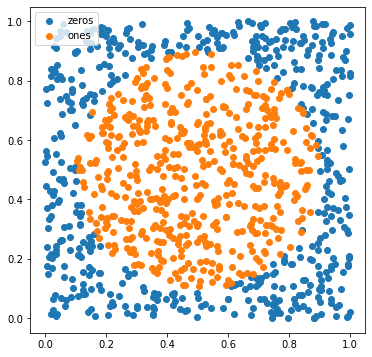

In [30]:
import matplotlib.pyplot as plt 

input, target = generate_disc_dataset(1000)

def plot_from_input(input, target):
    zeros = input[(target == 0).nonzero()[:,0]]
    ones = input[target.nonzero()[:,0]]
    plt.figure(figsize= (6,6))
    plt.scatter(zeros[:,0], zeros[:,1], label='zeros')
    plt.scatter(ones[:,0], ones[:,1], label= 'ones')
    plt.legend()
    plt.savefig('generated_data.png')
    plt.show()

plot_from_input(input, target)

## Train / Test

In [32]:
def train(model, train_input, train_target, learning_rate=0.0001, nb_epochs=500):
    
    criterion = LossMSE()
    optimizer = SGD(model.param(), learning_rate)
    
    for epoch in range(nb_epochs):
        
        acc_loss = 0

        for idx, input in enumerate(train_input):
            optimizer.zero_grad()
            output = model.forward(input)
            target = train_target[idx]
            
            loss = criterion.forward(output, target)
            #print(output, target, loss.item())
            acc_loss = acc_loss + loss.item()
            
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            optimizer.step()
            
            
        avg_acc_loss = acc_loss / train_input.shape[0]
        print(f"epoch {epoch}, Loss {avg_acc_loss}")
    return model

def train_adam(model, train_input, train_target, learning_rate=0.05, nb_epochs=500):
    
    criterion = LossMSE()
    optimizer = Adam(model.param(), learning_rate)
    
    for epoch in range(nb_epochs):
        
        acc_loss = 0

        for idx, input in enumerate(train_input):
            optimizer.zero_grad()
            output = model.forward(input)
            target = train_target[idx]
            
            loss = criterion.forward(output, target)
            #print(output, target, loss.item())
            acc_loss = acc_loss + loss.item()
            
            grad_loss = criterion.backward()
            model.backward(grad_loss)
            optimizer.step()
            
            
        
        print(f"epoch {epoch}, Loss {acc_loss}")
    return model


def test(model, test_input, test_label):
    nb_correct = 0
    nb_total = test_input.shape[0]
    x_0 = []
    y_0 = []
    x_1 = []
    y_1 = []
    
    for idx, input in enumerate(test_input):
        prediction = model.forward(input)
        target = test_label[idx]
        if prediction.argmax() == 0 :
            x_0.append(input[0])
            y_0.append(input[1])
        else :
            x_1.append(input[0])
            y_1.append(input[1])
            
        nb_correct += prediction.argmax() == target
    plt.figure(figsize= (6,6))
    plt.scatter(x_0, y_0, label='zeros')
    plt.scatter(x_1, y_1, label= 'ones')
    plt.legend()
    plt.show()
    print(nb_correct, nb_total, 100 * nb_correct/nb_total)
    

## Data creation and code 

Note: j'ai pas compris si on doit utiliser 1000 datasets pour le train + 1000 dataset pour le test, pour le moment j'ai fait 1000 pour les 2 et je split ensuite, à voir comment on veut faire 

Note: Si on veut faire un truc fancy et visualiser notre data, il faudrait faire l'opération "inverse" du normalize data sur le dataset 

TODO: lr hypertuning w/ validation ? 

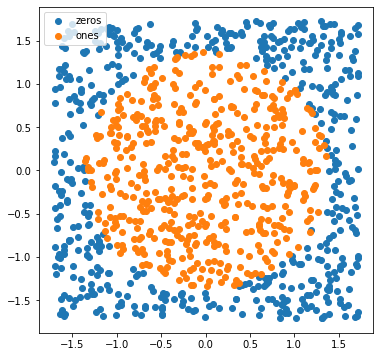

8
epoch 0, Loss 16.264354832823155
epoch 1, Loss 0.5584998461731011
epoch 2, Loss 0.3633561861856433
epoch 3, Loss 0.29660451833100526
epoch 4, Loss 0.25518018126499376
epoch 5, Loss 0.22694320861034795
epoch 6, Loss 0.20564472833345643
epoch 7, Loss 0.18989068501110887
epoch 8, Loss 0.17557598835614044
epoch 9, Loss 0.16218628207261646
epoch 10, Loss 0.15031278209548327
epoch 11, Loss 0.1410333510691762
epoch 12, Loss 0.1335433306766863
epoch 13, Loss 0.127667742104808
epoch 14, Loss 0.12272350399637252
epoch 15, Loss 0.11855785830985678
epoch 16, Loss 0.11508397267782856
epoch 17, Loss 0.11194458376604598
epoch 18, Loss 0.1094078005087722
epoch 19, Loss 0.10686253264949483
epoch 20, Loss 0.10474839836647436
epoch 21, Loss 0.10215081476926298
epoch 22, Loss 0.09955617164672731
epoch 23, Loss 0.09768734732529992
epoch 24, Loss 0.09580008124774395
epoch 25, Loss 0.09395884901109457
epoch 26, Loss 0.09250806942871122
epoch 27, Loss 0.09109298546598665
epoch 28, Loss 0.08981468161571683
e

epoch 231, Loss 0.0528450618459774
epoch 232, Loss 0.05273834598351459
epoch 233, Loss 0.05271099343565265
epoch 234, Loss 0.052786599655226384
epoch 235, Loss 0.052742197300754017
epoch 236, Loss 0.05260024633283865
epoch 237, Loss 0.0526358784748279
epoch 238, Loss 0.052551462351484134
epoch 239, Loss 0.05266344644228229
epoch 240, Loss 0.05247521952185707
epoch 241, Loss 0.05247849278062313
epoch 242, Loss 0.0524514294784376
epoch 243, Loss 0.052501289893187274
epoch 244, Loss 0.05243356178174736
epoch 245, Loss 0.052377993663239523
epoch 246, Loss 0.052398327667004196
epoch 247, Loss 0.052265422951262734
epoch 248, Loss 0.052203970555485285
epoch 249, Loss 0.052184095737567986
epoch 250, Loss 0.05213690451407217
epoch 251, Loss 0.05217068513495724
epoch 252, Loss 0.052049720251563486
epoch 253, Loss 0.05208307173758567
epoch 254, Loss 0.05207307714669423
epoch 255, Loss 0.052022489608621984
epoch 256, Loss 0.05200636715165456
epoch 257, Loss 0.05190857653687726
epoch 258, Loss 0.05

epoch 458, Loss 0.047899084605450296
epoch 459, Loss 0.047879469653377325
epoch 460, Loss 0.047845267538285954
epoch 461, Loss 0.04785112010012472
epoch 462, Loss 0.04782089943426399
epoch 463, Loss 0.04777106258533422
epoch 464, Loss 0.04784295050360652
epoch 465, Loss 0.04779791308294989
epoch 466, Loss 0.047787445696281336
epoch 467, Loss 0.04772206509817215
epoch 468, Loss 0.047790058755817426
epoch 469, Loss 0.04768985695365973
epoch 470, Loss 0.047742245034403365
epoch 471, Loss 0.04769171901124082
epoch 472, Loss 0.04766676474625842
epoch 473, Loss 0.04761063146608831
epoch 474, Loss 0.04766654556711785
epoch 475, Loss 0.047604260538148084
epoch 476, Loss 0.047621290129873615
epoch 477, Loss 0.04758057019421449
epoch 478, Loss 0.047564267063091394
epoch 479, Loss 0.04755812555453667
epoch 480, Loss 0.04756066943313999
epoch 481, Loss 0.047497150917308315
epoch 482, Loss 0.04755616194890536
epoch 483, Loss 0.047486135663699316
epoch 484, Loss 0.047489084788286166
epoch 485, Loss 

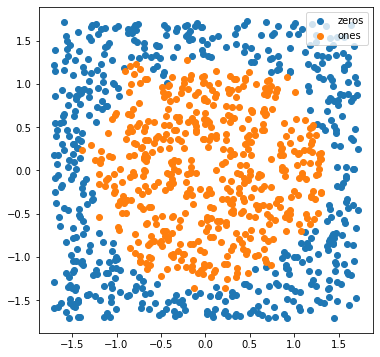

tensor([958]) 1000 tensor([95])


In [33]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)
plot_from_input(train_input, train_target)
# Pas sûr si on doit faire une activation fonction à la fin
model = Sequential([Linear(2, 16), ReLU(), Linear(16, 32), ReLU(), Linear(32, 32), ReLU(), Linear(32, 2)])
one_hot_targets = one_hot_encoder(train_target)

model = train(model, train_input, one_hot_targets)
test(model, test_input, test_target)

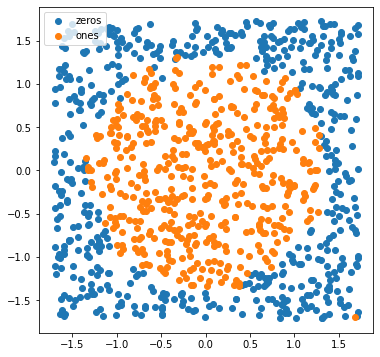

tensor([968]) 1000 tensor([96])


In [34]:
test(model, train_input, train_target)


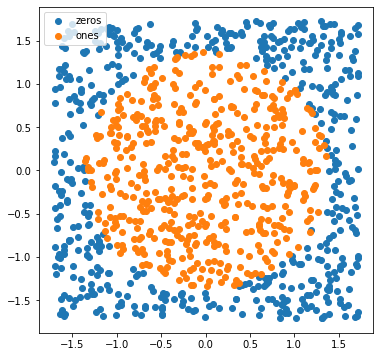

epoch 0, Loss 23166.226364004426
epoch 1, Loss 1914.8398691336624
epoch 2, Loss 1017.8032804009417
epoch 3, Loss 404.99493632192025
epoch 4, Loss 311.4223306797139
epoch 5, Loss 240.88241143268533
epoch 6, Loss 156.27997913640866
epoch 7, Loss 132.14139861074
epoch 8, Loss 100.65774127638451
epoch 9, Loss 100.37269927008128
epoch 10, Loss 86.6882315454477
epoch 11, Loss 90.44369171324433
epoch 12, Loss 84.98941174124684
epoch 13, Loss 95.03577003977443
epoch 14, Loss 78.45589260301881
epoch 15, Loss 87.4533679663258
epoch 16, Loss 59.565183086670004
epoch 17, Loss 52.44134433597242
epoch 18, Loss 62.81684827197216
epoch 19, Loss 55.80075034860522
epoch 20, Loss 52.015911388185145
epoch 21, Loss 54.33481116791222
epoch 22, Loss 52.492191486308
epoch 23, Loss 65.16475115357804
epoch 24, Loss 50.531994831892376
epoch 25, Loss 48.98085814999723
epoch 26, Loss 46.60235763905757
epoch 27, Loss 44.96338898257055
epoch 28, Loss 47.71275837537349
epoch 29, Loss 42.020023137511714
epoch 30, Loss

epoch 241, Loss 25.457361027035013
epoch 242, Loss 23.47514904312345
epoch 243, Loss 24.87451349703724
epoch 244, Loss 24.43644388636925
epoch 245, Loss 23.18760936731464
epoch 246, Loss 22.150204153541978
epoch 247, Loss 20.99965752819263
epoch 248, Loss 22.845662436805494
epoch 249, Loss 23.685298387360977
epoch 250, Loss 21.795830569890917
epoch 251, Loss 21.36124497178069
epoch 252, Loss 22.545551953480487
epoch 253, Loss 23.818064991976655
epoch 254, Loss 18.895115883526245
epoch 255, Loss 23.689371599932315
epoch 256, Loss 22.828056801653503
epoch 257, Loss 22.58340049707018
epoch 258, Loss 26.424292071195563
epoch 259, Loss 23.853458353235645
epoch 260, Loss 23.488649760655466
epoch 261, Loss 23.154020019832735
epoch 262, Loss 21.56808243696459
epoch 263, Loss 22.67736307304022
epoch 264, Loss 25.268181120731
epoch 265, Loss 26.31317423244249
epoch 266, Loss 23.079280429517027
epoch 267, Loss 26.213944625362892
epoch 268, Loss 25.45558069499913
epoch 269, Loss 22.912827882450877

epoch 478, Loss 16.569434372684213
epoch 479, Loss 15.058286558206019
epoch 480, Loss 19.901382520955543
epoch 481, Loss 22.694036083250776
epoch 482, Loss 21.582839710975968
epoch 483, Loss 16.206324278483073
epoch 484, Loss 18.227836505001747
epoch 485, Loss 17.08736720231546
epoch 486, Loss 17.145544428153126
epoch 487, Loss 17.528703146219872
epoch 488, Loss 13.671773889720223
epoch 489, Loss 18.158060458297548
epoch 490, Loss 27.390698001348635
epoch 491, Loss 19.004849042944493
epoch 492, Loss 17.46471490859239
epoch 493, Loss 15.539141920770525
epoch 494, Loss 25.34621718994397
epoch 495, Loss 28.006397314565113
epoch 496, Loss 22.01270506293291
epoch 497, Loss 19.878796684412897
epoch 498, Loss 27.58062035174305
epoch 499, Loss 15.952031379226778


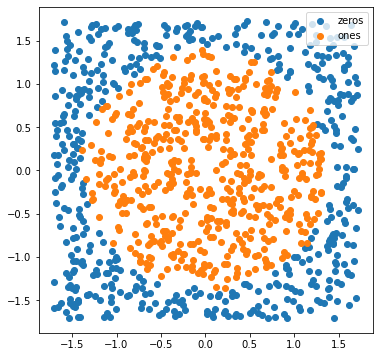

tensor([993]) 1000 tensor([99])


In [38]:
input, target = generate_disc_dataset(2000)
train_input, train_target, test_input, test_target = split_dataset(input, target, 0.5)
train_input, test_input = normalize_data(train_input, test_input)
plot_from_input(train_input, train_target)
# Pas sûr si on doit faire une activation fonction à la fin
model = Sequential([Linear(2, 16), ReLU(), Linear(16, 32), ReLU(), Linear(32, 32), ReLU(), Linear(32, 2)])
one_hot_targets = one_hot_encoder(train_target)

model = train_adam(model, train_input, one_hot_targets, learning_rate=0.01, nb_epochs=500)
test(model, test_input, test_target)